In [6]:
# !pip install spacy

In [8]:
# !python -m spacy download en_core_web_sm
# # !python -m spacy download en

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)
print(torch.cuda.is_available())

import torchtext
print(torchtext.__version__)

2.8.0+cu126
True
0.4.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from torchtext import data, datasets
from torchtext.vocab import GloVe
from torchtext.data import BucketIterator

from collections import Counter
import string
import random

import matplotlib.pyplot as plt

In [46]:
# For tokenization
TEXT = data.Field(tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    batch_first=True,
    fix_length=50,
    lower=True,
    )

# For multi-class classification labels
LABEL = data.LabelField()

# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

In [10]:
print(vars(train_data.examples[0]))

{'text': ['How', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'Russia', '?'], 'label': 'DESC'}


In [4]:
label_set = set()
for i in train_data:
    label_set.add(i.label)

print(label_set)

{'NUM', 'LOC', 'ENTY', 'DESC', 'HUM', 'ABBR'}


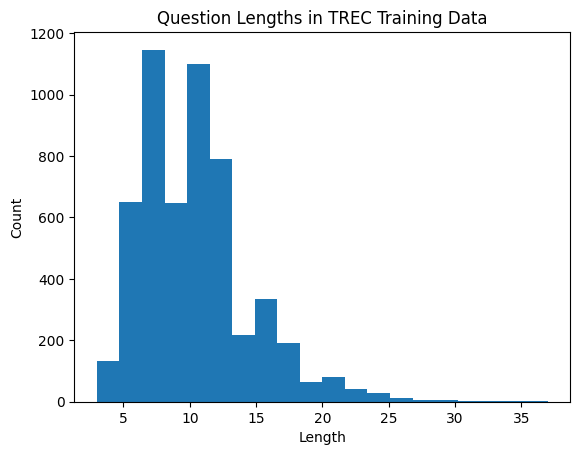

In [24]:
lengths = [len(example.text) for example in train_data]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=20)
plt.title("Question Lengths in TREC Training Data")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [25]:
print(f"Max length: {max(lengths)}")
print(f"Average length: {sum(lengths) / len(lengths):.2f}")
print(f"90th percentile: {sorted(lengths)[int(len(lengths)*0.9)]}")

Max length: 37
Average length: 10.43
90th percentile: 16


In [47]:
TEXT.build_vocab(train_data, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

In [48]:
embedding_dim = 100
vocab = TEXT.vocab
vectors = vocab.vectors.clone()
glove_vocab = set(vocab.stoi.keys())

# Subword parameters
ngram_min = 3
ngram_max = 6

# Count word frequency in training data
word_counter = Counter()
for example in train_data:
    word_counter.update([w.lower().strip(string.punctuation) for w in example.text])

# Threshold to consider a word “frequent” (adjustable)
freq_threshold = 3

# <unk> vector
unk_vector = torch.zeros(embedding_dim)

def get_subwords(word, n_min=3, n_max=6):
    word = f"<{word.lower()}>"
    subwords = []
    for n in range(n_min, n_max+1):
        subwords += [word[i:i+n] for i in range(len(word)-n+1)]
    return subwords

def get_word_vector(word):
    w_clean = word.lower().strip(string.punctuation)
    
    if w_clean in glove_vocab:
        return vectors[vocab.stoi[w_clean]]
    
    # Subword averaging
    subwords = get_subwords(w_clean, ngram_min, ngram_max)
    subword_vecs = [vectors[vocab.stoi[sg]] for sg in subwords if sg in glove_vocab]
    if subword_vecs:
        return torch.stack(subword_vecs).mean(0)
    
    # Random vector for frequent OOVs
    if word_counter[w_clean] >= freq_threshold:
        return torch.randn(embedding_dim)
    
    # <unk> for rare OOVs
    return unk_vector

# Build embedding matrix
embedding_matrix = {}
for example in train_data:
    for w in example.text:
        if w not in embedding_matrix:
            embedding_matrix[w] = get_word_vector(w)

In [49]:
embedding_matrix_tensor = torch.zeros(len(TEXT.vocab), embedding_dim)

# Fill the tensor with word embeddings from your dictionary
for word, idx in TEXT.vocab.stoi.items():
    # If the word has an embedding, assign it; otherwise, leave it as zero
    if word in embedding_matrix:
        embedding_matrix_tensor[idx] = embedding_matrix[word]
        
TEXT.vocab.vectors = embedding_matrix_tensor

In [50]:
train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(42))

train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=32,
    sort_within_batch=False,
    shuffle=True,
    device=device
)

In [12]:
print("train_iter size: ", len(train_iter))
print("valid_iter size: ", len(valid_iter))
print("test_iter size: ", len(test_iter))

train_iter size:  154
valid_iter size:  18
test_iter size:  16


In [86]:
class CNNModel(nn.Module):
    def __init__(self, embed_model=None, vocab_size=len(TEXT.vocab), output_size=6, embedding_dim=100,
                 num_filters=100, kernel_sizes=[3, 4, 5], freeze_embeddings=True, drop_prob=0.2):
        """
        Initialize the model by setting up the layers.
        """
        super(CNNModel, self).__init__()

        # set class vars
        self.num_filters = num_filters
        self.embedding_dim = embedding_dim
        
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # set weights to pre-trained
        # self.embedding.weight = nn.Parameter(torch.from_numpy(embed_model.vectors)) # all vectors
        self.embedding.weight.data.copy_(TEXT.vocab.vectors)
        
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False
            # embedding.weight.requires_grad = False
            
        # 2. convolutional layers
        self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim), padding=(k-2,0)) 
            for k in kernel_sizes])
        
        # 3. final, fully-connected layer for classification
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_size) 
        
        # 4. dropout and sigmoid layers
        self.dropout = nn.Dropout(drop_prob)
    
    def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = F.relu(conv(x)).squeeze(3)
        
        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

    def forward(self, x):
        """
        Defines how a batch of inputs, x, passes through the model layers.
        Returns a single, sigmoid-activated class score as output.
        """
        # embedded vectors
        embeds = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        # embeds.unsqueeze(1) creates a channel dimension that conv layers expect
        embeds = embeds.unsqueeze(1)
        
        # get output of each conv-pool layer
        conv_results = [self.conv_and_pool(embeds, conv) for conv in self.convs_1d]
        
        # concatenate results and add dropout
        x = torch.cat(conv_results, 1)
        x = self.dropout(x)
        
        # final logit
        logit = self.fc(x) 
        
        # sigmoid-activated --> a class score
        return logit

In [22]:
def train(model, train_iter, valid_iter, epochs=8):
    step_count = 0

    for e in range(epochs):
        correct_train = 0
        total_train = 0
        print('Training epoch ',e+1)
        model.train()
        train_iter.init_epoch()
        # batch loop
        for batch in train_iter:        

            x_train = batch.text.to(device)
            y_train = batch.label.to(device)
    
            # Forward pass
            y_model = model(x_train)
            
            # Loss function
            loss = criterion(y_model, y_train)
            if step_count%5 == 0 and step_count != 0:
                losses_train.append(float(loss))
    
            # Backward pass 
            optimizer.zero_grad()
            loss.backward()
            
            # Update parameters
            optimizer.step()

            preds = y_model.argmax(dim=1)
            correct_train += (preds == y_train).sum().item()
            total_train += y_train.size(0)
            # Evaluation in valid set
    
            if step_count%100 == 0:
                train_accuracy = correct_train / total_train if total_train > 0 else 0
                
                # Calculate model in valid set by pieces
                model.eval() # Set model to eval (if there is dropout, will set it to zero)
                valid_iter.init_epoch()
                correct_val = 0
                total_val = 0
                with torch.no_grad():
                    for valid_batch in valid_iter:            
                        x_val = valid_batch.text.to(device)
                        y_val = valid_batch.label.to(device)
                        y_val_pred = model(x_val).argmax(dim=1)
                        correct_val += (y_val_pred == y_val).sum().item()
                        total_val += y_val.size(0)
                val_accuracy = correct_val / total_val if total_val > 0 else 0
                model.train() # Set model to train (if there is dropout, will not be zero anymore)
                
                # Calculate accuracy
                # val_accuracy = float( (torch.cat(y_model_valid_list).max(dim=1)[1] == torch.cat(y_valid_list)).float().mean())
                print(f'Step: {step_count}, Train Accuracy: {train_accuracy:.4f}')
                print(f'Step: {step_count}, Val Accuracy: {val_accuracy:.4f}')

                train_accuracies.append(train_accuracy)
                val_accuracies.append(val_accuracy)

                correct_train = 0
                total_train = 0
                
            #lr_decay.step()
            step_count += 1


In [12]:
def evaluate(model,test_iter):
    model.eval()
    # iterate over test data
    y_preds = []
    y_trues = []
    
    with torch.no_grad():
        for batch in test_iter:
            x_test = batch.text.to(device)
            y_test = batch.label.to(device)

            # Forward pass
            preds = model(x_test)
            y_preds.append(preds)
            y_trues.append(y_test)
        
    y_preds = torch.cat(y_preds)
    y_trues = torch.cat(y_trues)
    
    predicted_classes = y_preds.argmax(dim=1)
    accuracy = (predicted_classes == y_trues).float().mean().item()
    print(f'Accuracy in test set:{accuracy:.4f}')
    return accuracy

In [108]:
model = CNNModel(embed_model=None, vocab_size=len(TEXT.vocab), output_size=6, embedding_dim=100,
                   num_filters=100, kernel_sizes=[3, 4, 5], drop_prob=0.3)
model.to(device)
print(model)

CNNModel(
  (embedding): Embedding(8536, 100)
  (convs_1d): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1), padding=(1, 0))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1), padding=(3, 0))
  )
  (fc): Linear(in_features=300, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [105]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

train_accuracies = []
val_accuracies = []
losses_train = []

train(model,train_iter,valid_iter,epochs=6)

Training epoch  1
Step: 0, Train Accuracy: 0.2188
Step: 0, Val Accuracy: 0.1450
Step: 100, Train Accuracy: 0.5816
Step: 100, Val Accuracy: 0.7560
Training epoch  2
Step: 200, Train Accuracy: 0.8564
Step: 200, Val Accuracy: 0.8083
Training epoch  3
Step: 300, Train Accuracy: 0.9387
Step: 300, Val Accuracy: 0.8358
Step: 400, Train Accuracy: 0.9333
Step: 400, Val Accuracy: 0.8606
Training epoch  4
Step: 500, Train Accuracy: 0.9722
Step: 500, Val Accuracy: 0.8743
Training epoch  5
Step: 600, Train Accuracy: 0.9929
Step: 600, Val Accuracy: 0.8752
Training epoch  6
Step: 700, Train Accuracy: 0.9961
Step: 700, Val Accuracy: 0.8661
Step: 800, Train Accuracy: 0.9953
Step: 800, Val Accuracy: 0.8835


In [14]:
def print_fig():
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
        
    ax[0].plot(range(len(losses_train)) , losses_train , 'go-' , label = 'Training Loss')
    ax[0].set_title('Training Loss')
    ax[0].legend()
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Loss")
    
    ax[1].plot(range(len(train_accuracies)) , train_accuracies , 'go-' , label = 'Training Accuracy')
    ax[1].plot(range(len(val_accuracies)) , val_accuracies , 'ro-' , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Eval_Steps")
    ax[1].set_ylabel("Accuracy")
    
    plt.show()
    print("train accs: ",train_accuracies)
    print("val accs: ",val_accuracies)

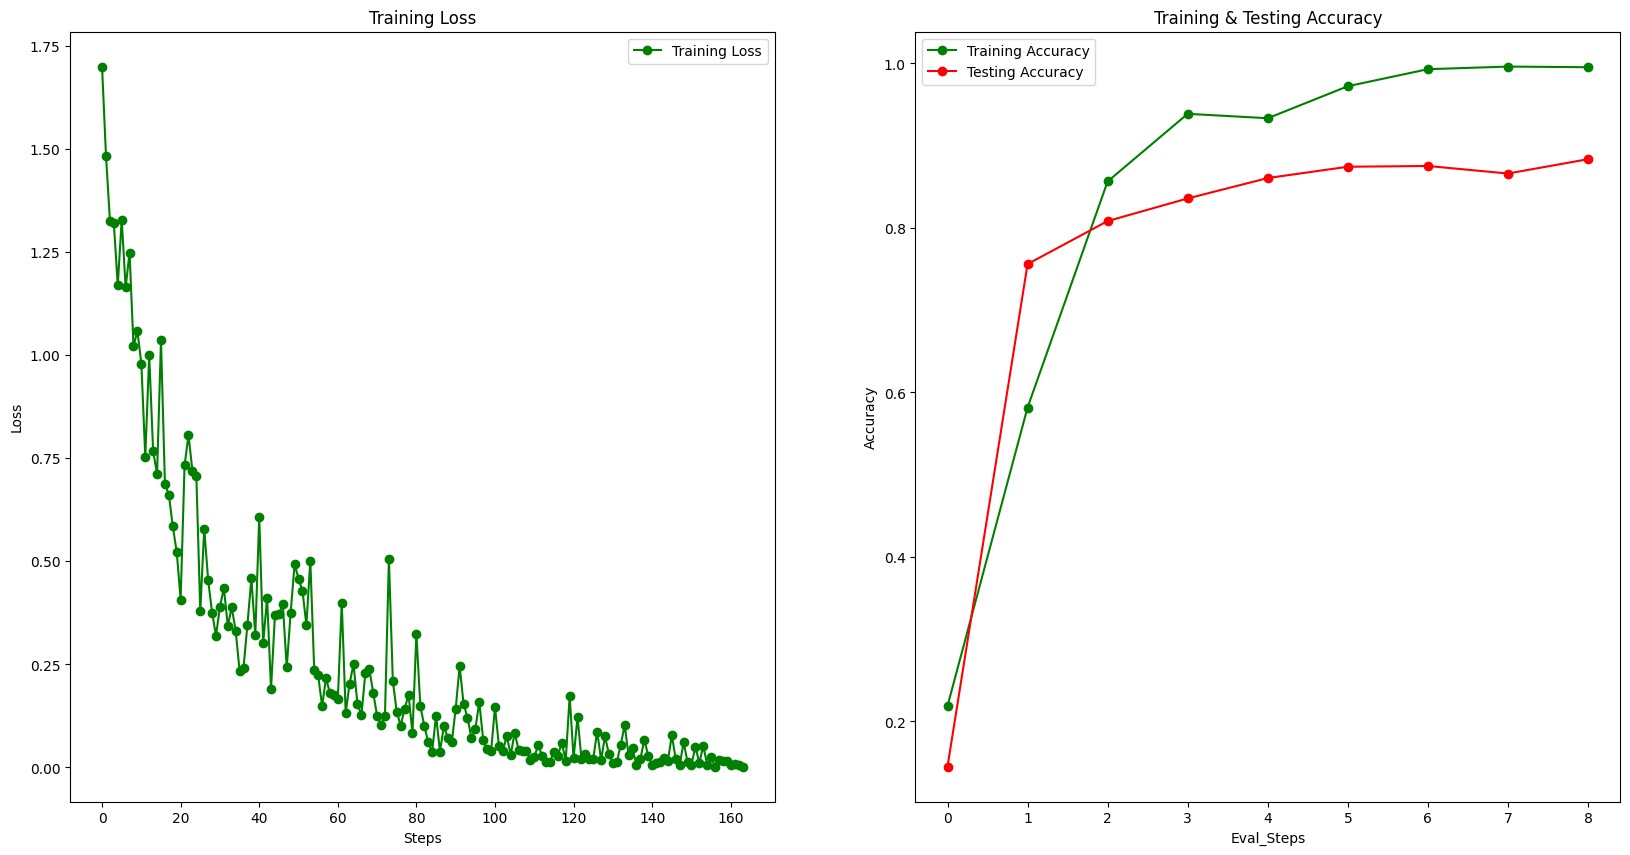

train accs:  [0.21875, 0.5815625, 0.8564453125, 0.9386574074074074, 0.933291378225299, 0.9722222222222222, 0.9929245283018868, 0.99609375, 0.9953125]
val accs:  [0.14495412844036698, 0.7559633027522936, 0.808256880733945, 0.8357798165137614, 0.8605504587155963, 0.8743119266055046, 0.8752293577981651, 0.8660550458715597, 0.8834862385321101]


In [107]:
print_fig()

In [58]:
evaluate(model,test_iter)

Accuracy in test set:0.9260


0.9260000586509705